<a href="https://colab.research.google.com/github/Kaleru-Pallavi/df/blob/main/2d/U_net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/2d

/content/gdrive/My Drive/2d


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.color as color
import random as r
import math
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from tensorflow.keras.callbacks import  ModelCheckpoint
from keras.optimizers import Adam
#
from keras import backend as K

In [4]:
!pip install hdf5storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.5 MB/s eta 0:00:00


Importing Libraries


In [5]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


In [6]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

In [7]:
images = images[..., np.newaxis]

In [8]:
masks = masks[..., np.newaxis]

Normalizing the Images


In [9]:
for i in range(images.shape[0]):
  images[i,:, :] = (images[i,:, :] - np.min(images[i,:, :]))/ (np.max(images[i,:, :])-np.min(images[i,:, :]) )

Evaluation Metrics

In [10]:
from keras.losses import binary_crossentropy
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

Splitting the dataset into Training, Validation and Test Set

In [11]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_test, images_cv, masks_test, masks_cv = train_test_split(images_test,masks_test,test_size = 0.5,train_size =0.5,random_state=1)

In [12]:
print ("number of training examples = " + str(images_train.shape[0]))
print ("number of development examples = " + str(images_cv.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("Images_train shape: " + str(images_train.shape))
print ("Masks_train shape: " + str(masks_train.shape))
print ("Images_val (dev) shape: " + str(images_cv.shape))
print ("Masks_val (dev) shape: " + str(masks_cv.shape))
print ("Images_test shape: " + str(images_test.shape))
print ("Masks_test shape: " + str(masks_test.shape))

number of training examples = 2451
number of development examples = 307
number of test examples = 306
Images_train shape: (2451, 512, 512, 1)
Masks_train shape: (2451, 512, 512, 1)
Images_val (dev) shape: (307, 512, 512, 1)
Masks_val (dev) shape: (307, 512, 512, 1)
Images_test shape: (306, 512, 512, 1)
Masks_test shape: (306, 512, 512, 1)


Model


In [13]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics=[dice_coef])

    model.summary()
    return model

In [14]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate
# from tensorflow.keras.optimizers import Adam

# Define a custom Dice coefficient for the metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.cast(y_true, 'float32')  # Convert y_true to float32
    y_pred_f = tf.keras.backend.cast(y_pred, 'float32')  # Convert y_pred to float32
    y_true_f = tf.keras.backend.flatten(y_true_f)
    y_pred_f = tf.keras.backend.flatten(y_pred_f)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)


def unet(input_size=(512, 512, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Fix: Use 'inputs' and 'outputs' arguments for the Model
    model = Model(inputs=inputs, outputs=conv10)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[dice_coef])

    # Display model summary
    model.summary()
    return model


To save chekpoints

In [15]:

filepath="cnn-parameters-improvement-{epoch:02d}-{dice_coef:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}".format(filepath), monitor='dice_coef', verbose=1, save_best_only=True, mode='max')
# checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor=[dice_coef], verbose=1, save_best_only=True, mode='max'))

Training the model


In [16]:
model=unet()
# model.fit(images_train, masks_train, batch_size=2, nb_epoch=30, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])
model.fit(images_train, masks_train, batch_size=2, epochs=5, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 512, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 128)  │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 256)  │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 64, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 32, 32, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,031,685 (118.38 MB)

 Trainable params: 31,031,685 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - dice_coef: 0.0322 - loss: 0.6787
Epoch 1: dice_coef improved from -inf to 0.03218, saving model to models/cnn-parameters-improvement-01-0.03.keras
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 771s 576ms/step - dice_coef: 0.0322 - loss: 0.6786 - val_dice_coef: 0.0332 - val_loss: 0.6366
Epoch 2/5
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - dice_coef: 0.0320 - loss: 0.6233
Epoch 2: dice_coef did not improve from 0.03218
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 706s 539ms/step - dice_coef: 0.0320 - loss: 0.6233 - val_dice_coef: 0.0331 - val_loss: 0.5848
Epoch 3/5
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - dice_coef: 0.0316 - loss: 0.5724
Epoch 3: dice_coef did not improve from 0.03218
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 665s 525ms/step - dice_coef: 0.0316 - loss: 0.5724 - val_dice_coef: 0.0330 - val_loss: 0.5371
Epoch 4/5
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - dice_coef: 0.0309 - loss: 0.5254
Epoch 4: dice_coef did not improve from 0.03218
1226/12

In [ ]:
model.save('trained_model.keras')

In [22]:
results = model.evaluate(images_test, masks_test, batch_size=2)
print('dice_coeff:', results)

153/153 ━━━━━━━━━━━━━━━━━━━━ 25s 161ms/step - dice_coef: 0.0317 - loss: 0.4519
dice_coeff: [0.45192939043045044, 0.03179090842604637]


Training the model a bit more!

In [24]:
model.fit(images_train, masks_train, batch_size=2, epochs=3, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])

Epoch 1/3
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - dice_coef: 0.0318 - loss: 0.4423
Epoch 1: dice_coef did not improve from 0.03218
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 644s 525ms/step - dice_coef: 0.0318 - loss: 0.4423 - val_dice_coef: 0.0325 - val_loss: 0.4147
Epoch 2/3
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - dice_coef: 0.0317 - loss: 0.4056
Epoch 2: dice_coef did not improve from 0.03218
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 681s 524ms/step - dice_coef: 0.0317 - loss: 0.4055 - val_dice_coef: 0.0324 - val_loss: 0.3802
Epoch 3/3
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - dice_coef: 0.0320 - loss: 0.3719
Epoch 3: dice_coef did not improve from 0.03218
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 700s 539ms/step - dice_coef: 0.0320 - loss: 0.3719 - val_dice_coef: 0.0322 - val_loss: 0.3486


In [ ]:
model.fit(images_train, masks_train, batch_size=2, epochs=3, verbose=1,validation_data=(images_cv,masks_cv), callbacks=[checkpoint])

Epoch 1/3
1109/1226 ━━━━━━━━━━━━━━━━━━━━ 59s 506ms/step - dice_coef: 0.0314 - loss: 0.3415

In [ ]:
model.save('trained_model_1.keras')

In [ ]:
dependencies = {
     'dice_coef': dice_coef
}
model = keras.models.load_model('trained_model_1', custom_objects=dependencies)

Evaluating on test set


In [ ]:
results = model.evaluate(images_test, masks_test, batch_size=2)
print('loss,dice_coeff:', results)

153/153 [==============================] - 83s 545ms/step - loss: 0.0455 - dice_coef: 0.6727
dice_coeff: [0.04554812237620354, 0.6726678609848022]


Making Predictions

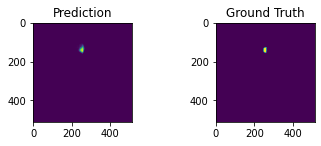

In [ ]:
predictions = model.predict(images_train[0:1,:])
plt.subplot(221)
plt.title('Prediction')
plt.imshow(predictions[0,:,:,0])
plt.subplot(222)
plt.title('Ground Truth')
plt.imshow(masks_train[0,:,:,0])

Chnaging the loss to bce_dice_loss

In [ ]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss=[bce_dice_loss], metrics=[dice_coef])

    model.summary()
    return model

In [ ]:
model=unet()
model.fit(images_train, masks_train, batch_size=2, nb_epoch=50, verbose=1,validation_data=(images_cv,masks_cv))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_170 (Conv2D)             (None, 512, 512, 64) 640         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_170[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_171[0][0]                 
____________________________________________________________________________________________

In [ ]:
model.save('trained_model_4.h5')

In [ ]:

dependencies = {
     'dice_coef': dice_coef,
     'bce_dice_loss': bce_dice_loss
}
model = keras.models.load_model('trained_model_4.h5',custom_objects=dependencies)

In [ ]:
results = model.evaluate(images_test, masks_test, batch_size=2)
print('dice_coeff:', results)

153/153 [==============================] - 77s 505ms/step - loss: 0.3920 - dice_coef: 0.6663
dice_coeff: [0.39204278588294983, 0.6662623882293701]
